# Question 1: Graph Classification

In this question we will be exploring graph classification on the dataset provided.

Overall, we will explore ways to implement graph level classification using GCNs; explore the given dataset and see how we can improve the GCN & training process overall to get a higher score on the dataset.

### HELPER FUNCTION & IMPORTS:

In [164]:
#Import Statements
import json
import torch
import os
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import networkx as nx
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [165]:
TRAIN_FILE_NAME = "q1_graph_classification_main_train.json"
EVAL_FILE_NAME = "q1_graph_classification_main_eval.json"

TRAIN_DATA_PATH = os.path.join("data",TRAIN_FILE_NAME)
EVAL_DATA_PATH = os.path.join("data",EVAL_FILE_NAME)

In [190]:
# Training function
def train_epoch(model, dataset, optimizer, criterion, return_embeddings=False, **kwargs):
    model.train()
    total_loss = 0
    all_embeddings_H1 = []
    all_labels_H1 = []

    for X, A, label in dataset:
        optimizer.zero_grad()

        # Forward pass with optional embeddings
        if return_embeddings:
            output, H1, _ = model(A, X, return_embeddings=True, **kwargs)
            all_embeddings_H1.append(H1.detach().cpu().numpy())  # Store H1 embeddings
        else:
            output = model(A, X, **kwargs)

        # Prepare label for BCELoss
        adjusted_label = 1 if label == 1 else 0
        label_tensor = torch.tensor([float(adjusted_label)], dtype=torch.float)
        all_labels_H1.append(label_tensor.detach().cpu().numpy())

        # Flatten the output to match the label tensor shape
        output_flat = output.view(-1)

        # Compute loss
        loss = criterion(output_flat, label_tensor)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(dataset)

    if return_embeddings:
        return average_loss, (all_embeddings_H1,all_labels_H1)
    else:
        return average_loss


# Testing function
def test(model, dataset, **kwargs):
    model.eval()
    true_labels = []
    predicted_labels = []
    correct = 0

    with torch.no_grad():
        for X, A, label in dataset:
            output = model(A, X, **kwargs)

            # Convert sigmoid output to binary prediction
            predicted = (output >= 0.5).int().item()

            # Adjust labels to match binary predictions (0 and 1)
            adjusted_label = 1 if label == 1 else 0

            true_labels.append(adjusted_label)
            predicted_labels.append(predicted)
            correct += (predicted == adjusted_label)

    accuracy = correct / len(dataset)
    return true_labels, predicted_labels, accuracy


In [191]:
# Functions to load the data
def create_Adj_matrix(N, edge_index):
    """Creates the adjacency matrix"""
    A = torch.zeros((N, N), dtype=torch.float)
    for idx, jdx in edge_index:
        A[idx, jdx] = 1
        A[jdx, idx] = 1
    return A

def read_json_data(file_path, has_label=True):
    with open(file_path, 'r') as f:
        data = json.load(f)
        
    graph_data = []
    for item in data:
        X = torch.tensor(item['features'], dtype=torch.float)
        N = len(X)
        A = create_Adj_matrix(N, item['edge_index'])
        if has_label:
            y = torch.tensor(item['label'], dtype=torch.long)
        else:
            y = None
        
        graph_data.append((X,A,y))
    
    return graph_data


## Question 1.1 - Graph-Level Aggregation and Training

### Graph Convolutional Network (GCN)

We are going to use a 2-layer GCN for the **binary node classification** task on the heterogeneous graph. Below, you can see the mathematical representation to generate predictions from GCN.

The feature update rule for the next layer $ H_{k+1} $ in a graph convolutional network is given by the equation

$$
H_{k+1} = \sigma(\tilde{D}^{-1/2} \tilde{A} \tilde{D}^{-1/2} H_k \Omega_k + \beta)
$$

where  $\tilde{D}$ is the degree matrix with added self-loops, $\tilde{A}$ is the adjacency matrix with self-loops, $H_k$ are the features from the previous layer, $ \Omega_k $ is the weight matrix at layer $ k $, $\Beta_k$ is the bias vector at layer $k$, and $\sigma $ denotes the activation function.


$\tilde{D}^{-1/2} \tilde{A} \tilde{D}^{-1/2}$ is the normalized adjacency matrix with self-loops. Below, you need to implement this normalization function.

In [192]:
# Helper function to normalise the A matrix
def symmetric_normalize(A_tilde):
    """
    Performs symmetric normalization of A_tilde (Adj. matrix with self loops):
      A_norm = D^{-1/2} * A_tilde * D^{-1/2}
    Where D_{ii} = sum of row i in A_tilde.

    A_tilde (N, N): Adj. matrix with self loops
    Returns:
      A_norm : (N, N)
    """

    eps = 1e-5
    d = A_tilde.sum(dim=1) + eps
    D_inv = torch.diag(torch.pow(d, -0.5))
    return D_inv @ A_tilde @ D_inv

### Q1.1.a - Graph-Level GCN

Implement three graph-level aggregation methods: sum, mean, and max. A GCN implementation is provided, and your task is to adapt it into a graph-level GCN by integrating different
aggregation functions.

In [ ]:
# SOLUTION Q1.1.a

# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################
class MyGCNLayer(nn.Module):
    """
    A single layer of a Graph Convolutional Network (GCN).
    """
    def __init__(self, input_dim, output_dim, use_nonlinearity=True):
        super(MyGCNLayer, self).__init__()
        self.use_nonlinearity = use_nonlinearity
        self.Omega = nn.Parameter(torch.randn(input_dim, output_dim) * torch.sqrt(torch.tensor(2.0) / (input_dim + output_dim)))
        self.beta = nn.Parameter(torch.zeros(output_dim))

    def forward(self, H_k, A_normalized):
        agg = torch.matmul(A_normalized, H_k) # local agg
        H_k_next = torch.matmul(agg, self.Omega) + self.beta
        return F.relu(H_k_next) if self.use_nonlinearity else H_k_next

class MyGraphNeuralNetwork(nn.Module):
    """
    A simple Graph Neural Network model using two layers of Graph Convolutional Network (GCN)
    for binary classification. The sigmoid activation is applied in the output layer only if
    use_nonlinearity is set to True.
    """
    def __init__(self, input_dim, hidden_dim):
        super(MyGraphNeuralNetwork, self).__init__()

        # Define GCN layers
        self.gcn1 = MyGCNLayer(input_dim, hidden_dim, True)
        self.gcn2 = MyGCNLayer(hidden_dim, 1, False)

    def forward(self, A, X, graph_aggregation_method='mean', **kwargs):
        # Apply self-connections and normalize adjacency matrix
        A = A + torch.eye(A.size(0)) # to get A_tilde
        A_normalized = symmetric_normalize(A)
        # Pass through GCN layers
        H1 = self.gcn1(X, A_normalized)
        H2 = self.gcn2(H1, A_normalized)  # Output shape: (num_nodes, 1)

        # Perform graph aggregation based on the method passed as parameter
        aggregated_output = global_aggregation(H2, graph_aggregation_method)
        graph_output = torch.sigmoid(aggregated_output)

        if torch.isnan(graph_output).any():
            graph_output = torch.where(torch.isnan(graph_output), torch.zeros_like(graph_output), graph_output)

        if kwargs.get("return_embeddings", None):
            return graph_output, H1, H2
        else:
            return graph_output
        
def global_aggregation(H_k, graph_aggregation_method='mean'):
    """
    Performs global aggregation of the graph nodes based on the specified method.
    Args:
        - H_k (torch.Tensor): Output of the last GCN layer (shape: (num_nodes, 1))
        - graph_aggregation_method (str): Method to aggregate the graph nodes:
                                            - 'sum': returns the sum over all graph nodes
                                            - 'max': returns the element-wise maximum value of all graph nodes
                                            - 'mean': returns the mean of all graph nodes
                                            - [OPTIONAL] 'none': performs no aggregation and returns the 
                                                                output of the last GCN layer
                                            Any other mode will default to 'mean'.
    Returns:
        - aggregated_output (torch.Tensor): Aggregated output based on the specified method
    """
    if graph_aggregation_method == 'sum':
        # graph sum aggregation: gets the sum of all graph nodes
        aggregated_output = torch.sum(H_k, dim=0)
    elif graph_aggregation_method == 'max':
        # graph max aggregation: gets the element-wise maximum value of all graph nodes
        aggregated_output = torch.max(H_k, dim=0).values
    else:
        if graph_aggregation_method != 'none':
            # use default mean aggregation: gets the mean of all graph nodes
            aggregated_output = torch.mean(H_k, dim=0)
        else:
            # [OPTIONAL] no aggregation: returns the output of the last GCN layer
            aggregated_output = H_k

    return aggregated_output
        
# ####################################################
# END OF MODIFICATION
# ####################################################

### Test your solution runs for all three aggregation methods.

Note - the input dataset features have dimensionionality 10.

In [223]:
# Preparing the Basics:
# Load data
test_data = read_json_data(EVAL_DATA_PATH) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
X,A,_ = test_data[0]

model = MyGraphNeuralNetwork(input_dim=10, hidden_dim=5)

# Get the output of the different aggregations
out_no_agg =  global_aggregation(X, 'none')
out_sum_agg =  global_aggregation(X, 'sum')
out_mean_agg =  global_aggregation(X, 'mean')
out_max_agg =  global_aggregation(X, 'max')

# Check output shapes after aggregation
print("Input shape:", X.shape)
print("- No Aggregation out shape:", out_no_agg.shape)
print("- Sum Aggregation out shape:", out_sum_agg.shape)
print("- Mean Aggregation out shape:", out_mean_agg.shape)
print("- Max Aggregation out shape:", out_max_agg.shape)

# Check output values with different aggregations
print("\nNo Aggregation euqal to input?:", torch.equal(out_no_agg, X))
print("- Sum Aggregation out value:", out_sum_agg)
print("- Mean Aggregation out value:", out_mean_agg)
print("- Max Aggregation out value:", out_max_agg)

# Check forward pass with aggregation
out, H1, H2 = model(A, X, return_embeddings=True)
print("\nForward pass output shapes:\nH1:", H1.shape, "\nH2:", H2.shape, "\nAggregated Output:", out, "\nnAggregated Out Shape", out.shape)

Input shape: torch.Size([30, 10])
- No Aggregation out shape: torch.Size([30, 10])
- Sum Aggregation out shape: torch.Size([10])
- Mean Aggregation out shape: torch.Size([10])
- Max Aggregation out shape: torch.Size([10])

No Aggregation euqal to input?: True
- Sum Aggregation out value: tensor([ 0.9494,  0.8534, -1.4443,  0.6333, -0.2278, -0.8318,  1.0503, -2.8748,
        -1.7380, -0.8759])
- Mean Aggregation out value: tensor([ 0.0316,  0.0284, -0.0481,  0.0211, -0.0076, -0.0277,  0.0350, -0.0958,
        -0.0579, -0.0292])
- Max Aggregation out value: tensor([0.4975, 0.5088, 0.3148, 0.3455, 0.2975, 0.4293, 0.5854, 0.5626, 0.4775,
        0.3554])

Forward pass output shapes:
H1: torch.Size([30, 5]) 
H2: torch.Size([30, 1]) 
Aggregated Output: tensor([0.4874], grad_fn=<SigmoidBackward0>) 
nAggregated Out Shape torch.Size([1])


### A full end-2-end Training script (make sure the below runs)

You only need to modify the aggregation parameter in this case.

In [ ]:
# ADDED HELPER FUNCTIONS
# Preparing the Basics:
from statistics import mean

# Evaluate the model on the test set with different aggregation methods
def run_test(model, eval_data, **kwargs):
    true_labels, predicted_labels, accuracy = test(model, eval_data)
    # Debug: Print true and predicted labels
    print("True labels:", true_labels)
    print("Predicted labels:", predicted_labels)

    # Calculate precision, recall (sensitivity), and F1-score
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    # Print out the evaluation metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

def run_train(model, optimizer, criterion, graph_aggregation_method, train_data, num_epochs=10, **kwargs):
    loss_values = []
    for epoch in range(num_epochs):
        # Train without returning embeddings for other epochs
        # note train_epoch accepts the additional param graph_aggregation_method and passes it (via kwargs) to the model.forward method.
        train_loss = train_epoch(model, train_data, optimizer, criterion, graph_aggregation_method=graph_aggregation_method)
        print(f"Epoch {epoch+1}, Loss: {train_loss}")
        loss_values.append(train_loss)
    return loss_values

In [ ]:
# Load data
train_data = read_json_data(TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
eval_data = read_json_data(EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

random.shuffle(train_data)

# Training
num_epochs = 10
input_dim = 10
hidden_dim = 8

# ####################################################
# MODIFY THE CODE BELOW 
# (note only aggregation param - and make sure to run all of them)
# ####################################################  

# Initialize a list to store loss values for visualization
loss_values = []
loss_per_agg = []

# define aggregation method
aggregation_methods = ["mean", "sum", "max"]

for aggregation in aggregation_methods:
    print(f"\n------- Using '{aggregation}' aggregation -------")
     # Initialising the model
    model = MyGraphNeuralNetwork(input_dim, hidden_dim)
    print(model)
    # Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train model
    loss_values = run_train(model, optimizer, criterion, graph_aggregation_method=aggregation, train_data=train_data, num_epochs=num_epochs)
    loss_per_agg.append(mean(loss_values))
    # Evaluate model
    run_test(model, eval_data, graph_aggregation_method=aggregation)

print("\nMean loss per aggregation method:")
for agg, train_loss in zip(aggregation_methods, loss_per_agg):
    print(f"- {agg}: {train_loss}")

# ####################################################
# END OF MODIFICATION
# ####################################################   


------- Using 'mean' aggregation -------
MyGraphNeuralNetwork(
  (gcn1): MyGCNLayer()
  (gcn2): MyGCNLayer()
)
Epoch 1, Loss: 0.6471832566189043
Epoch 2, Loss: 0.5833120725371621
Epoch 3, Loss: 0.5617638474160974
Epoch 4, Loss: 0.5559720735658299
Epoch 5, Loss: 0.5535915569035392
Epoch 6, Loss: 0.551961339219953
Epoch 7, Loss: 0.5505392407490448
Epoch 8, Loss: 0.5492005204273895
Epoch 9, Loss: 0.5478965312694059
Epoch 10, Loss: 0.5466232075722832
True labels: [0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1]
Predicted labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Accuracy: 0.5000
Precision: 0.2500
Recall: 0.5000
F1-score: 0.3333

------- Using 'sum' aggregation -------
MyGraphNeuralNetwork(
  (gcn1): MyGCNLayer()
  

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2, Loss: 0.36807380577881826
Epoch 3, Loss: 0.3578760048787279
Epoch 4, Loss: 0.35340455844892527
Epoch 5, Loss: 0.3508746948615281
Epoch 6, Loss: 0.3490580083417819
Epoch 7, Loss: 0.3475599792824748
Epoch 8, Loss: 0.34628877014796616
Epoch 9, Loss: 0.3452513258459724
Epoch 10, Loss: 0.3442999802910807
True labels: [0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1]
Predicted labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Accuracy: 0.5000
Precision: 0.2500
Recall: 0.5000
F1-score: 0.3333

------- Using 'max' aggregation -------
MyGraphNeuralNetwork(
  (gcn1): MyGCNLayer()
  (gcn2): MyGCNLayer()
)
Epoch 1, Loss: 0.6157321671419071
Epoch 2, Loss: 0.5579535139329506
Epoch 3, Loss: 0.5421598191852822


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4, Loss: 0.5359447075223381
Epoch 5, Loss: 0.5308625941926782
Epoch 6, Loss: 0.5257057013046561
Epoch 7, Loss: 0.5200762854832591
Epoch 8, Loss: 0.5141678910815355
Epoch 9, Loss: 0.5081155931464199
Epoch 10, Loss: 0.5023276691014568
True labels: [0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1]
Predicted labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Accuracy: 0.5000
Precision: 0.2500
Recall: 0.5000
F1-score: 0.3333

Mean loss per aggregation method:
- mean: 0.5648043646279609
- sum: 0.3552348739394361
- max: 0.5353045942092484


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Q1.1.b. Graph-Level Training

Make modifications to the training script to:
1. Train the model and record the training loss and evaluation accuracy for each epoch.
2. Plot the test f1 for all three aggregation methods.

Use the provided functions:

• train model

• plot training and evaluation

In [225]:
# Helper function for plotting:

def plot_training_and_validation(training_losses, validation_losses, aggregation="mean", graph1_label="Training Accuracy", graph2_label="Validation Accuracy", x_label="Epoch", title=None, save=False, plot_name=""):
    """
    Plots the validation accuracy and training loss over epochs.
    Args:
        validation_losses: List of validation accuracies (or losses)
        training_losses: List of training accuracies (or losses)
        aggregation: Aggregation method used (default: "mean")
    """
    plt.figure(figsize=(10, 6))
    
    # Create figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()
    
    # Plot training loss on the first y-axis
    epochs = range(1, len(training_losses) + 1)
    line1 = ax1.plot(epochs, training_losses, 'orchid', label=f'{graph1_label}')
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(f'{graph1_label}', color='orchid')
    ax1.tick_params(axis='y', labelcolor='orchid')
    
    # Plot validation accuracy on the second y-axis
    line2 = ax2.plot(epochs, validation_losses, 'cornflowerblue', label=f'{graph2_label}')
    ax2.set_ylabel(f'{graph2_label}', color='cornflowerblue')
    ax2.tick_params(axis='y', labelcolor='cornflowerblue')
    
    # Add title and grid
    if not title:
        title = f'Training Accuracy and Validation Accuracy Over Time\nAggregation: {aggregation}'
    plt.title(title)

    ax1.grid(True)
    
    # Add legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right')
    
    plt.tight_layout()
    if save:
        fig_name = f"images/Q1/{plot_name}.pdf"
        plt.savefig(fig_name, format="pdf")
    plt.show()

In [ ]:
# SOLUTION Q1.1.b
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  

# ADDED HELPER FUNCTION
def run_epoch(model, dataset, optimizer, criterion, return_embeddings=False, train=True, **kwargs):
    """
    Runs a single epoch of training or evaluation. Adapted from the original 'train_epoch' function.
    Args:
        - model (nn.Module): The GCN model
        - dataset (list): The dataset used to train or perform validation
        - optimizer (torch.optim): The optimizer used for training
        - criterion (torch.nn): The loss function
        - return_embeddings (bool): Whether to return the model's embeddings or not
        - train (bool): Whether to train (True) the model or validate (False)
        - kwargs: Additional keyword arguments to pass to the model's forward method
    Returns:
        - average_loss (float): The average model loss over the given dataset
        - accuracy (float): The accuracy  over the given dataset
        - (predicted_labels, true_labels) (tuple): the predicted and true labels over the given dataset
        - (all_embeddings_H1, adjusted_label) (tuple): the H1 embeddings and adjusted labels
                                                        NB: Only returned if 'return_embeddings' is True 
    """
    if train:
        model.train()
    else:
        model.eval()
        return_embeddings = False

    total_loss = 0
    true_labels = []
    predicted_labels = []
    correct = 0

    if return_embeddings:
        all_layer_embeddings = []
        all_layer_labels = []

    for X, A, label in dataset:
        if train:
            optimizer.zero_grad()
            # Forward pass with optional embeddings
            if return_embeddings:
                output, graph_embeddings = model(A, X, return_embeddings=True, **kwargs)
                all_layer_embeddings.append([H.detach().cpu().numpy() for H in graph_embeddings])  # Store layer embeddings
            else:
                output = model(A, X, **kwargs)
        else:
            with torch.no_grad():
                output = model(A, X, **kwargs)

        # Prepare label for BCELoss
        adjusted_label = 1 if label == 1 else 0
        true_labels.append(adjusted_label)

        label_tensor = torch.tensor([float(adjusted_label)], dtype=torch.float)
        if return_embeddings:
            all_layer_labels.append(label_tensor.detach().cpu().numpy())   

        # Flatten the output to match the label tensor shape
        output_flat = output.view(-1)

        # Compute loss
        loss = criterion(output_flat, label_tensor)

        if train:
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        total_loss += loss.item()

        # Accuracy
        predicted = (output >= 0.5).int().item()
        predicted_labels.append(predicted)
        correct += (predicted == adjusted_label)

    accuracy = correct / len(dataset)
    average_loss = total_loss / len(dataset)
    if train:
        if return_embeddings:
            return average_loss, accuracy, (predicted_labels, true_labels), (all_layer_embeddings, adjusted_label)
        else:
            return average_loss, accuracy, (predicted_labels, true_labels)
    else:
        return average_loss, accuracy, (predicted_labels, true_labels)


def train_model(model, optimizer, criterion, train_dataset, validation_dataset, epochs, graph_aggregation_method, verbose, f1 = False):
    """Trains the model and records loss and validation accuracy
    Args:
        - model (nn.Module): The GCN model
        - optimizer (torch.optim): The optimizer used for training
        - criterion (torch.nn): The loss function
        - train_dataset (list): The dataset used to train the model
        - validation_dataset (list): The dataset used for validation
        - epochs (int): The number of epochs to train the model
        - graph_aggregation_method (str): Chosen method for global graph aggegation
        - f1 (bool): Whether to calculate training and validation F1 scores or not
    Returns:
        - train_losses (list): The average model loss over the training dataset
        - train_accuracies (list): The average accuracy over the training dataset
        - eval_losses (list): The average model loss over the validation dataset
                              NB: Only returned if 'f1' is True 
        - eval_accuracies (list): The average accuracy over the validation dataset
        - train_F1 (list): The F1 scores over the training dataset
                            NB: Only returned if 'f1' is True 
        - eval_F1 (list): The F1 scores over the validation dataset
                            NB: Only returned if 'f1' is True 

    """
    train_losses, train_accuracies, eval_losses, eval_accuracies = [], [], [], []
    train_F1, eval_F1 = [], []

    for epoch in range(epochs):
        # 1. Train for each epoch (without returning embeddings)
        train_loss, train_acc, (train_predicted_labels, train_true_labels) = run_epoch(model=model, 
                                                                                       dataset=train_dataset, 
                                                                                       optimizer=optimizer, 
                                                                                       criterion=criterion, 
                                                                                       return_embeddings=False, 
                                                                                       train=True, 
                                                                                       graph_aggregation_method=graph_aggregation_method)        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # 2. Evaluate for each epoch (without returning embeddings)
        eval_loss, eval_acc, (eval_predicted_labels, eval_true_labels) = run_epoch(model=model, 
                                                                                   dataset=validation_dataset, 
                                                                                   optimizer=optimizer, 
                                                                                   criterion=criterion, 
                                                                                   return_embeddings=False, 
                                                                                   train=False, 
                                                                                   graph_aggregation_method=graph_aggregation_method)
        eval_losses.append(eval_loss)
        eval_accuracies.append(eval_acc)

        if f1:
            train_epoch_f1 = f1_score(train_true_labels, train_predicted_labels, average='macro')
            train_F1.append(train_epoch_f1)
            eval_epoch_f1 = f1_score(eval_true_labels, eval_predicted_labels, average='macro')
            eval_F1.append(eval_epoch_f1)

        # INCLUDE THiS STATEMENT IN YOUR CODE
        if (verbose) and ((epoch + 1) % 10 == 0):
            print(f"Epoch {epoch+1}:")
            print(f"     Train Loss: {train_loss}, Train Accuracy: {train_acc:.4f}")
            print(f"     Validation Loss: {eval_loss}, Validation Accuracy: {eval_acc:.4f}")
            # Print F1 scores ONLY if f1 is set to True
            if f1:
                print(f"     Training F1: {train_epoch_f1:.4f}, Validation F1: {eval_epoch_f1:.4f}")

    # return F1 scores ONLY if f1 is set to True
    if f1:
        return train_losses, train_accuracies, eval_losses, eval_accuracies, train_F1, eval_F1
    return train_losses, train_accuracies, eval_accuracies


# ####################################################
# END OF MODIFICATION
# ####################################################  

------- Using 'mean' aggregation -------
Epoch 10:
     Train Loss: 0.545049637048082, Train Accuracy: 0.7500
     Validation Loss: 0.8306144759058952, Validation Accuracy: 0.5000
Epoch 20:
     Train Loss: 0.5366804040968418, Train Accuracy: 0.7500
     Validation Loss: 0.8282932008306185, Validation Accuracy: 0.5000
Epoch 30:
     Train Loss: 0.5300632320400892, Train Accuracy: 0.7500
     Validation Loss: 0.8272198868294557, Validation Accuracy: 0.5000
Epoch 40:
     Train Loss: 0.52547523396259, Train Accuracy: 0.7500
     Validation Loss: 0.8243374414741993, Validation Accuracy: 0.5000
Epoch 50:
     Train Loss: 0.5220908326040389, Train Accuracy: 0.7500
     Validation Loss: 0.822324584176143, Validation Accuracy: 0.5000
Epoch 60:
     Train Loss: 0.5197210362830171, Train Accuracy: 0.7500
     Validation Loss: 0.8212005493541559, Validation Accuracy: 0.5000
Epoch 70:
     Train Loss: 0.5179384816720178, Train Accuracy: 0.7614
     Validation Loss: 0.8200592088202635, Validation 

<Figure size 1000x600 with 0 Axes>

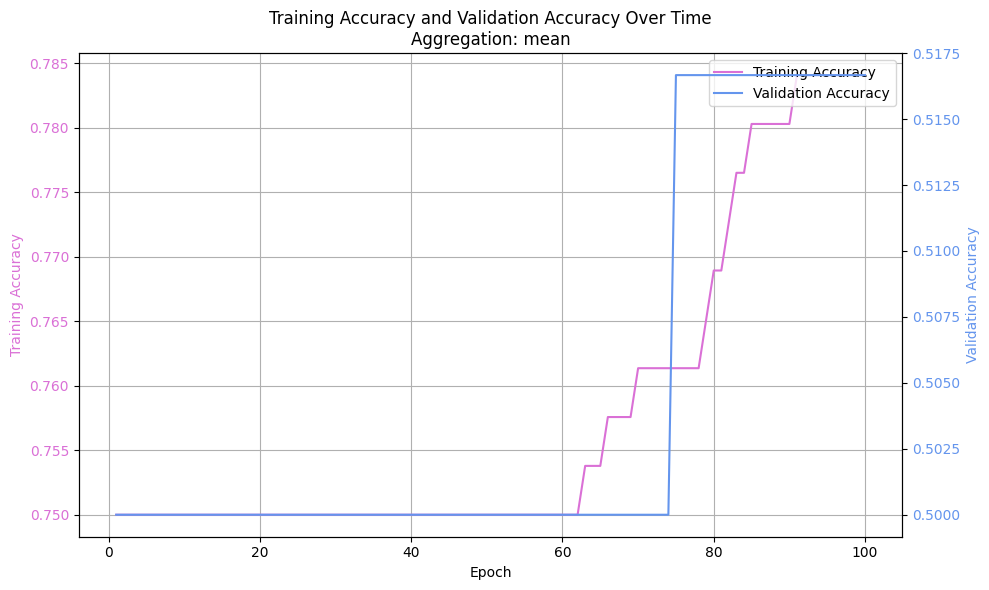

------- Using 'sum' aggregation -------
Epoch 10:
     Train Loss: 0.3482349471922851, Train Accuracy: 0.7500
     Validation Loss: 0.6067016297951341, Validation Accuracy: 0.5167
Epoch 20:
     Train Loss: 0.33561456407363893, Train Accuracy: 0.7727
     Validation Loss: 0.6038907965024313, Validation Accuracy: 0.5167
Epoch 30:
     Train Loss: 0.32587456063960085, Train Accuracy: 0.7841
     Validation Loss: 0.6128972850119074, Validation Accuracy: 0.5500
Epoch 40:
     Train Loss: 0.3186933395459853, Train Accuracy: 0.7992
     Validation Loss: 0.6251311701722443, Validation Accuracy: 0.5333
Epoch 50:
     Train Loss: 0.3131545204739792, Train Accuracy: 0.8106
     Validation Loss: 0.6346872681441407, Validation Accuracy: 0.5167
Epoch 60:
     Train Loss: 0.30846980674135865, Train Accuracy: 0.8144
     Validation Loss: 0.6383089201524854, Validation Accuracy: 0.5167
Epoch 70:
     Train Loss: 0.3045827358939939, Train Accuracy: 0.8220
     Validation Loss: 0.6418637794132034, Valid

<Figure size 1000x600 with 0 Axes>

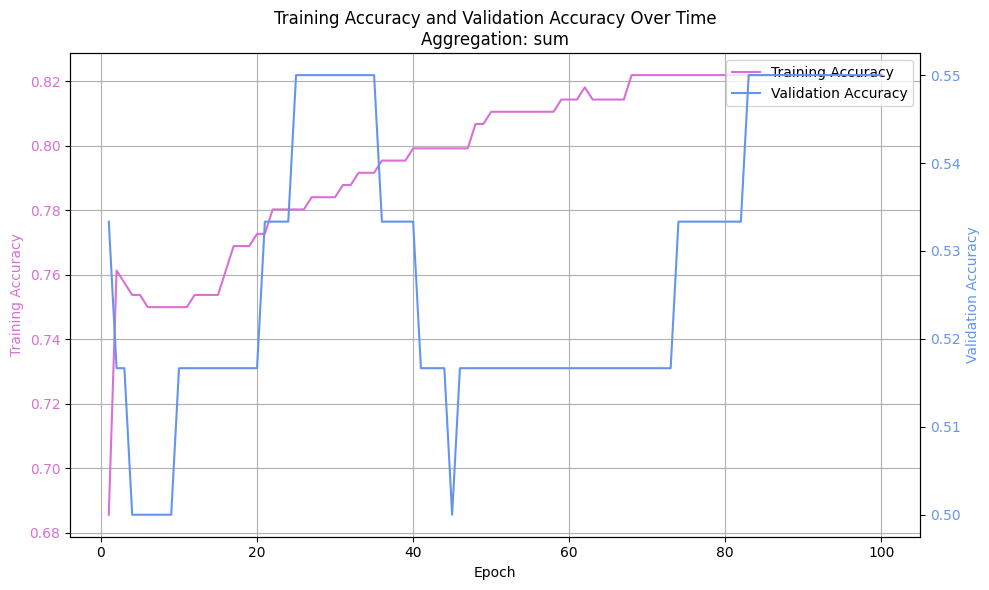

------- Using 'max' aggregation -------
Epoch 10:
     Train Loss: 0.49838850192838546, Train Accuracy: 0.7614
     Validation Loss: 0.7802792546649774, Validation Accuracy: 0.5000
Epoch 20:
     Train Loss: 0.443845533610632, Train Accuracy: 0.8106
     Validation Loss: 0.7246261175721884, Validation Accuracy: 0.5667
Epoch 30:
     Train Loss: 0.4119184714615006, Train Accuracy: 0.8598
     Validation Loss: 0.6887935190151135, Validation Accuracy: 0.6167
Epoch 40:
     Train Loss: 0.3929264888160326, Train Accuracy: 0.8750
     Validation Loss: 0.6642787122478088, Validation Accuracy: 0.6667
Epoch 50:
     Train Loss: 0.38137139480518684, Train Accuracy: 0.8750
     Validation Loss: 0.649114260263741, Validation Accuracy: 0.6833
Epoch 60:
     Train Loss: 0.37219434459058737, Train Accuracy: 0.8750
     Validation Loss: 0.6360431239319344, Validation Accuracy: 0.7000
Epoch 70:
     Train Loss: 0.3653175878483153, Train Accuracy: 0.8788
     Validation Loss: 0.6278971777297556, Validat

<Figure size 1000x600 with 0 Axes>

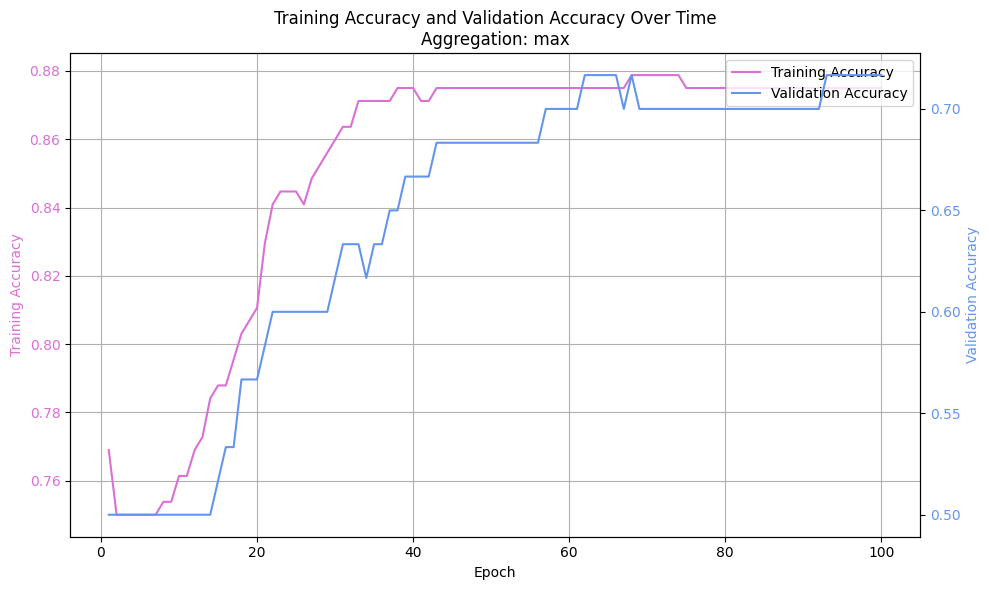

In [227]:
# Run all three aggregation functions here.
# Load data
train_data = read_json_data(TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
eval_data = read_json_data(EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# Initialising the model
input_dim = 10
hidden_dim = 8

aggregation_methods = ["mean", "sum", "max"]

# TRAIN
num_epochs = 100
for i,aggregation in enumerate(aggregation_methods):
    model = MyGraphNeuralNetwork(input_dim, hidden_dim)
    # print(model)
    # Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print(f"------- Using '{aggregation}' aggregation -------")
    # Train 3 identical models separately with different aggregation methods
    train_losses, train_accuracies, validation_accuracies = train_model(
        model, 
        optimizer, 
        criterion, 
        train_data, 
        eval_data, 
        epochs=num_epochs, 
        graph_aggregation_method=aggregation,
        verbose=True,
        f1 = False
    )
    # Visualising
    plot_training_and_validation(train_accuracies, validation_accuracies, aggregation=aggregation, save=True, plot_name=f"{aggregation}_acc")

### Q1.1.c - Training vs. Evaluation F1

Additionally, compare training F1 scores vs. evaluation F1 scores. What differences do you
observe? Which aggregation function performs best and why (sum, mean, or max)?

------- Using 'mean' aggregation -------
Epoch 10:
     Train Loss: 0.5503547407799598, Train Accuracy: 0.7500
     Validation Loss: 0.8257185871402423, Validation Accuracy: 0.5000
     Training F1: 0.4286, Validation F1: 0.3333
Epoch 20:
     Train Loss: 0.5359686413836299, Train Accuracy: 0.7538
     Validation Loss: 0.825555074463288, Validation Accuracy: 0.5000
     Training F1: 0.4444, Validation F1: 0.3333
Epoch 30:
     Train Loss: 0.526723899455233, Train Accuracy: 0.7614
     Validation Loss: 0.8302649147808552, Validation Accuracy: 0.5000
     Training F1: 0.4749, Validation F1: 0.3333
Epoch 40:
     Train Loss: 0.5208887245054498, Train Accuracy: 0.7727
     Validation Loss: 0.8361087702214718, Validation Accuracy: 0.5167
     Training F1: 0.5175, Validation F1: 0.3693
Epoch 50:
     Train Loss: 0.5167522966918169, Train Accuracy: 0.7765
     Validation Loss: 0.841283405572176, Validation Accuracy: 0.5167
     Training F1: 0.5311, Validation F1: 0.3693
Epoch 60:
     Train L

<Figure size 1000x600 with 0 Axes>

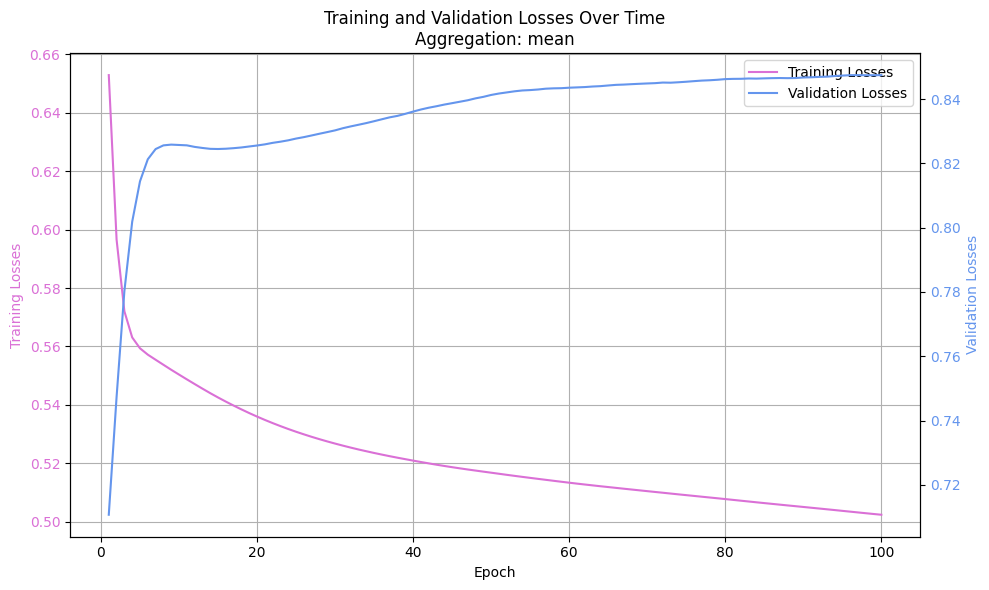

<Figure size 1000x600 with 0 Axes>

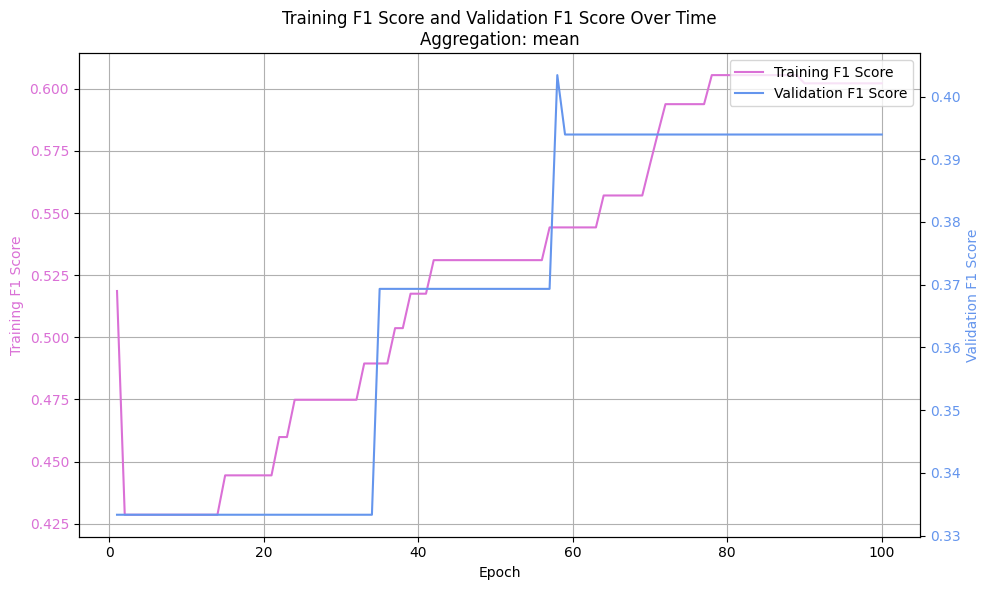

------- Using 'sum' aggregation -------
Epoch 10:
     Train Loss: 0.3358884684434584, Train Accuracy: 0.7576
     Validation Loss: 0.6521603186925252, Validation Accuracy: 0.5000
     Training F1: 0.4598, Validation F1: 0.3333
Epoch 20:
     Train Loss: 0.32162270598487475, Train Accuracy: 0.7803
     Validation Loss: 0.6522557166560242, Validation Accuracy: 0.5167
     Training F1: 0.5442, Validation F1: 0.3693
Epoch 30:
     Train Loss: 0.30927375320144085, Train Accuracy: 0.7841
     Validation Loss: 0.6523271893616766, Validation Accuracy: 0.5167
     Training F1: 0.5571, Validation F1: 0.3693
Epoch 40:
     Train Loss: 0.29993274454142066, Train Accuracy: 0.7879
     Validation Loss: 0.6572226433937127, Validation Accuracy: 0.5000
     Training F1: 0.5696, Validation F1: 0.3608
Epoch 50:
     Train Loss: 0.2924363307503165, Train Accuracy: 0.8144
     Validation Loss: 0.669523329140308, Validation Accuracy: 0.5167
     Training F1: 0.6498, Validation F1: 0.3939
Epoch 60:
     Tra

<Figure size 1000x600 with 0 Axes>

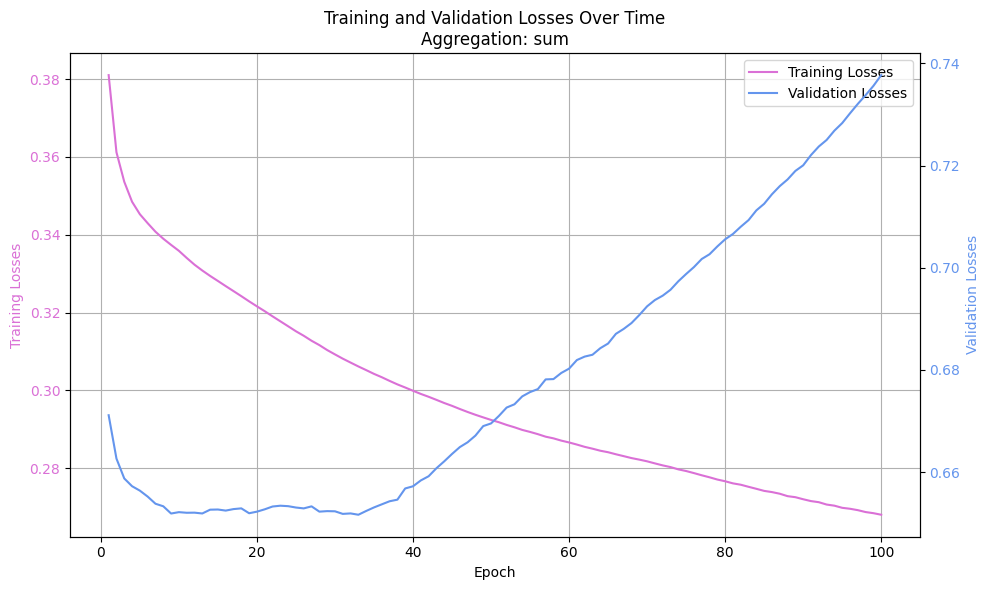

<Figure size 1000x600 with 0 Axes>

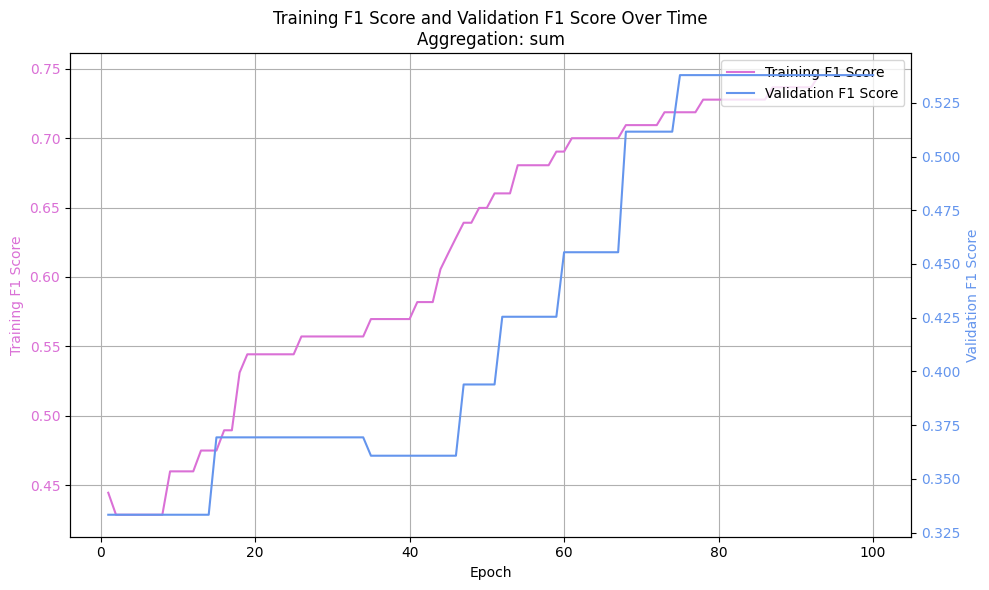

------- Using 'max' aggregation -------
Epoch 10:
     Train Loss: 0.4758248958510883, Train Accuracy: 0.7576
     Validation Loss: 0.7274833731353283, Validation Accuracy: 0.5500
     Training F1: 0.4730, Validation F1: 0.4357
Epoch 20:
     Train Loss: 0.4283993571333474, Train Accuracy: 0.8258
     Validation Loss: 0.6801437959074974, Validation Accuracy: 0.6333
     Training F1: 0.6972, Validation F1: 0.5764
Epoch 30:
     Train Loss: 0.4095449225172739, Train Accuracy: 0.8409
     Validation Loss: 0.6584571614861489, Validation Accuracy: 0.7167
     Training F1: 0.7448, Validation F1: 0.6919
Epoch 40:
     Train Loss: 0.4016482710898289, Train Accuracy: 0.8485
     Validation Loss: 0.647059986864527, Validation Accuracy: 0.7500
     Training F1: 0.7639, Validation F1: 0.7333
Epoch 50:
     Train Loss: 0.3974759779485987, Train Accuracy: 0.8485
     Validation Loss: 0.6437469685760637, Validation Accuracy: 0.7667
     Training F1: 0.7703, Validation F1: 0.7532
Epoch 60:
     Train 

<Figure size 1000x600 with 0 Axes>

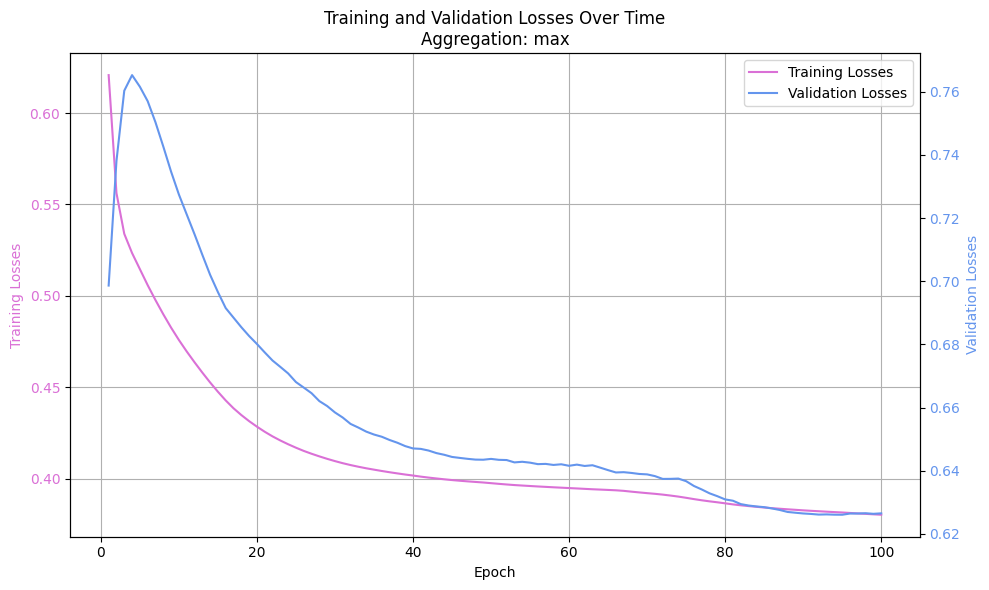

<Figure size 1000x600 with 0 Axes>

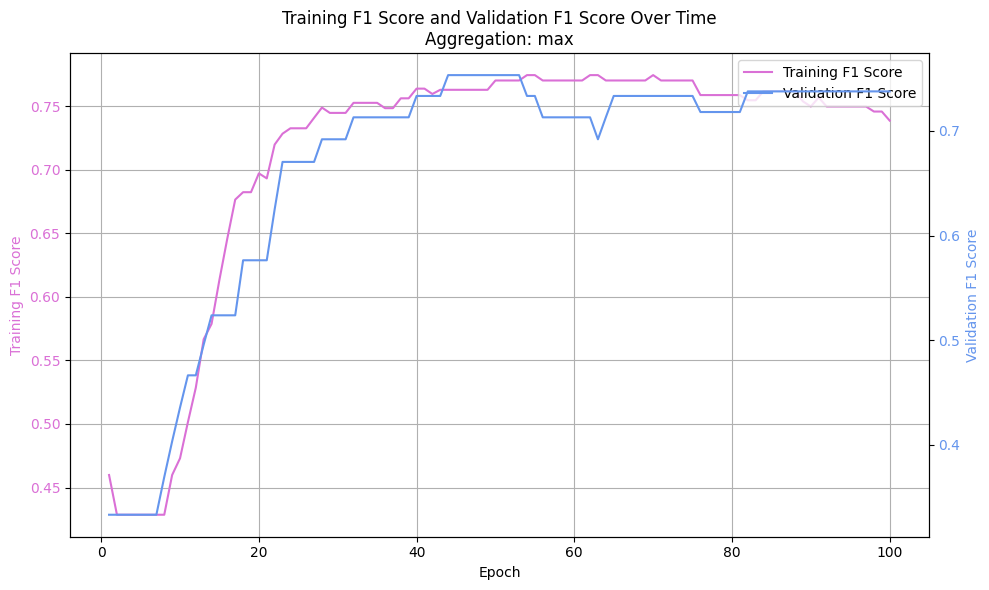

In [228]:
# Solution Q1.1.c
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  

train_data = read_json_data(TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
eval_data = read_json_data(EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# Initialising the model
input_dim = 10
hidden_dim = 8

aggregation_methods = ["mean", "sum", "max"]


num_epochs = 100
for i,aggregation in enumerate(aggregation_methods):
    model = MyGraphNeuralNetwork(input_dim, hidden_dim)
    # print(model)
    # Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print(f"------- Using '{aggregation}' aggregation -------")
    # Train 3 identical models separately with different aggregation methods
    train_losses, train_accuracies, validation_losses, validation_accuracies, train_F1, eval_F1 = train_model(
        model, 
        optimizer, 
        criterion, 
        train_data, 
        eval_data, 
        epochs=num_epochs, 
        graph_aggregation_method=aggregation,
        verbose=True,
        f1=True
    )

    plot_training_and_validation(train_losses, validation_losses, aggregation=aggregation, graph1_label="Training Losses", graph2_label="Validation Losses", x_label="Epoch", title=f"Training and Validation Losses Over Time\nAggregation: {aggregation}", save=True, plot_name=f"{aggregation}_loss")
    plot_training_and_validation(train_F1, eval_F1, aggregation=aggregation, graph1_label="Training F1 Score", graph2_label="Validation F1 Score", x_label="Epoch", title=f"Training F1 Score and Validation F1 Score Over Time\nAggregation: {aggregation}", save=True, plot_name=f"{aggregation}_f1")

# ####################################################
# END OF MODIFICATION
# ####################################################  


## Q1.2 - Analyzing the Dataset

You may notice that the model performs worse on the evaluation dataset. The goal of this task
is to analyze the dataset and identify potential issues that might affect the model’s performance.


In [ ]:
# Helper function to visualise graphs:
def visualize_graph(G, save=False, plot_name=""):
    """
    Visualize the generated graph.
    Params:
        - G (nx.Graph): The generated graph
        - save (bool): Whether to save the plot or not. Saved images
                        by default are in the 'images/Q1' folder.
        - plot_name (str): The name of the file to save the plot
    """
    pos = nx.spring_layout(G)

    # Draw the graph
    plt.figure(figsize=(10, 8))
    nx.draw(
        G, pos, with_labels=True,
        node_size=500, font_size=8, font_color="white", edge_color="gray"
    )
    plt.title("Homogenous Graph Visualization")
    if save:
        fig_name = f"images/Q1/{plot_name}.pdf"
        plt.savefig(fig_name, format="pdf")
    plt.show()

def visualise_graph_features(features_0, features_1, save=False, plot_name=""):
    """
    Plot clusters and their distribution
    Params:
        - features_0 (list): features for class 0
        - features_1 (list): features for class 1
        - save (bool): Whether to save the plot or not. Saved images
                        by default are in the 'images/Q1' folder.
        - plot_name (str): The name of the file to save the plot
    """
    plt.figure(figsize=(10, 8))
    
    # Convert to numpy arrays and get the first feature dimension
    features_0_np_1 = np.array(features_0)[:, 0]  # Take first feature dimension
    features_0_np_2 = np.array(features_0)[:, 1]  # Take second feature dimension
    
    features_1_np_1 = np.array(features_1)[:, 0]  # Take first feature dimension
    features_1_np_2 = np.array(features_1)[:, 1]  # Take second feature dimension
   
    plt.scatter(features_0_np_1, features_0_np_2, alpha=0.7, label='Class 0', color='cornflowerblue')
    plt.scatter(features_1_np_1, features_1_np_2, alpha=0.7, label='Class 1', color='plum')

    plt.xlabel('First Feature Dimension')
    plt.ylabel('Second Feature Dimension')
    # plt.ylabel('Class') 
    # plt.yticks([0, 1], ['Class 0', 'Class 1'])
    plt.title('Feature Distribution by Class')
    plt.legend()
    if save:
        fig_name = f"images/Q1/{plot_name}.pdf"
        plt.savefig(fig_name, format="pdf")
    plt.show()

### Q1.2.a - Plotting
• Plot the topologies of the graphs.

• Plot the feature distributions.

• Plot the label distributions.

In [ ]:
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  
def plot_class_distribution(labels, dataset_name = 'Training', save=False, plot_name=f""):
    """
    Plot the distribution of labels.
    Params:
        - labels (list): The list of labels in the dataset
        - dataset_name (str): The name of the dataset (Training, Validation, or Test)
        - save (bool): Whether to save the plot or not. Saved images
                        by default are in the 'images/Q1' folder.
        - plot_name (str): The name of the file to save the plot
    """
    label_classes = {}
    for label in labels:
        if label not in label_classes.keys():
            label_classes[label] = 1
        else:
            label_classes[label] += 1

    class_types = list(label_classes.keys())

    fig, ax = plt.subplots(figsize=(10, 6))
    plt.bar(class_types, label_classes.values(), color='orchid', alpha=0.7, edgecolor='plum')
    ax.set_xticks(class_types)
    ax.set_xticklabels(class_types)
    plt.xlabel("Class Labels")
    plt.ylabel("Class Counts")
    plt.title(f"Distribution of Classes in {dataset_name} Dataset")
    if len(class_types) > 5:
        plt.xticks(rotation=45)
    if save:
        fig_name = f"images/Q1/{plot_name}.pdf"
        plt.savefig(fig_name, format="pdf")
    plt.show()


def plot_graph_topology(A, save=False, plot_name=""):
    """
    Plot the graph topology from the adjacency matrix.
    Params:
        - A (torch.Tensor): The graph's adjacency matrix
        - save (bool): Whether to save the plot or not
        - plot_name (str): The name of the file to save the plot. Saved 
                           images by default are in the 'images/Q1' folder.
    """
    G = nx.from_numpy_array(A.numpy())
    visualize_graph(G, save=save, plot_name=plot_name)

# ####################################################
# END OF MODIFICATION
# #################################################### 

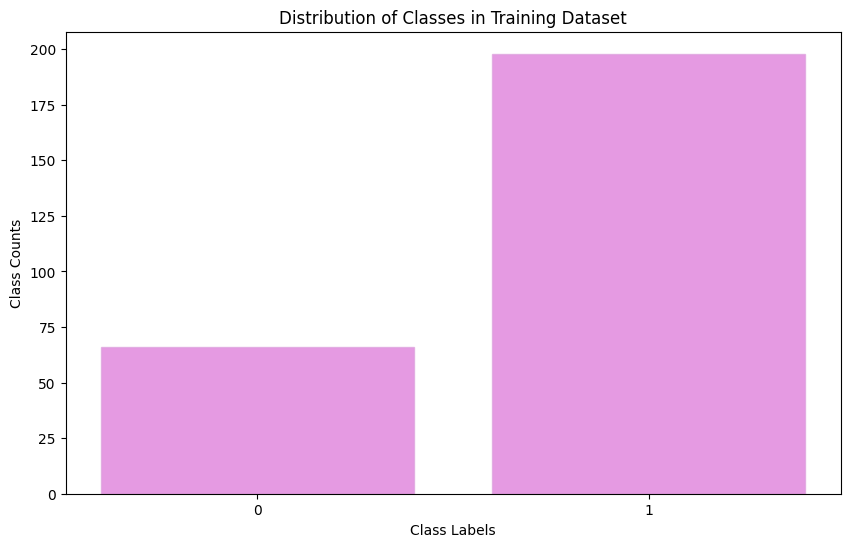

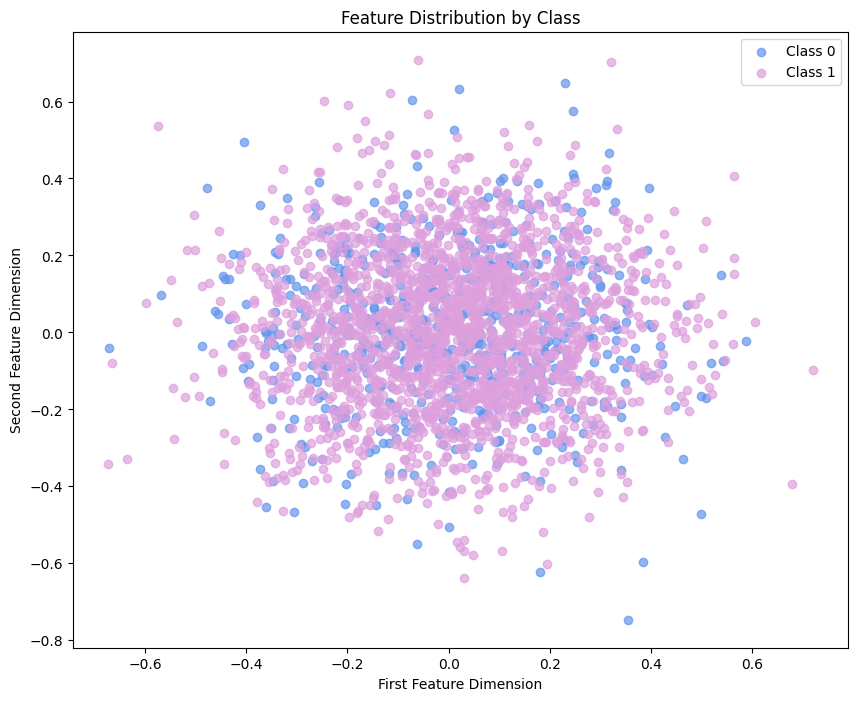

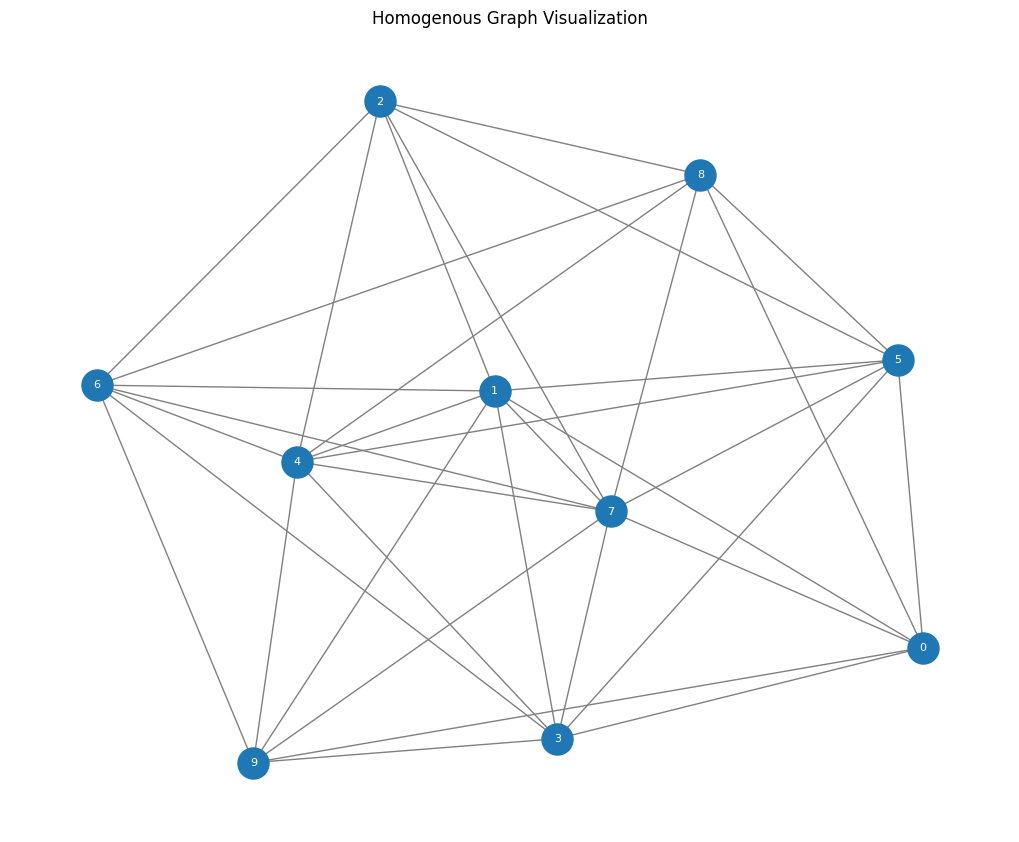

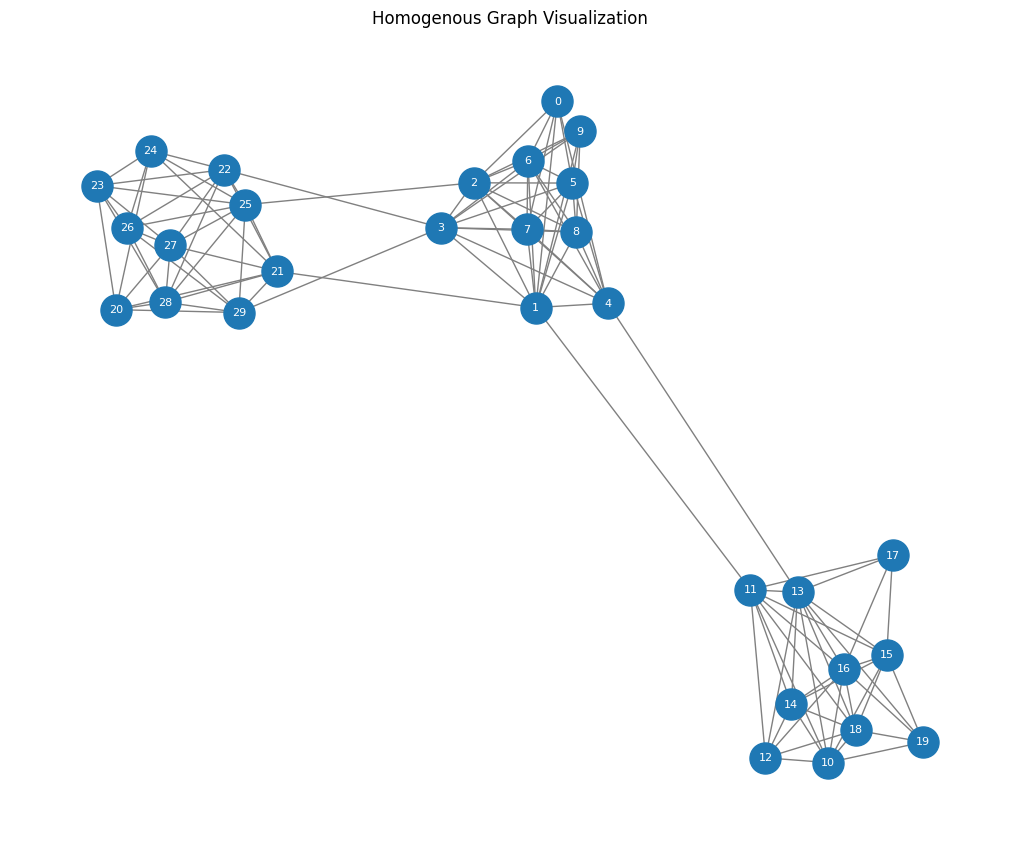

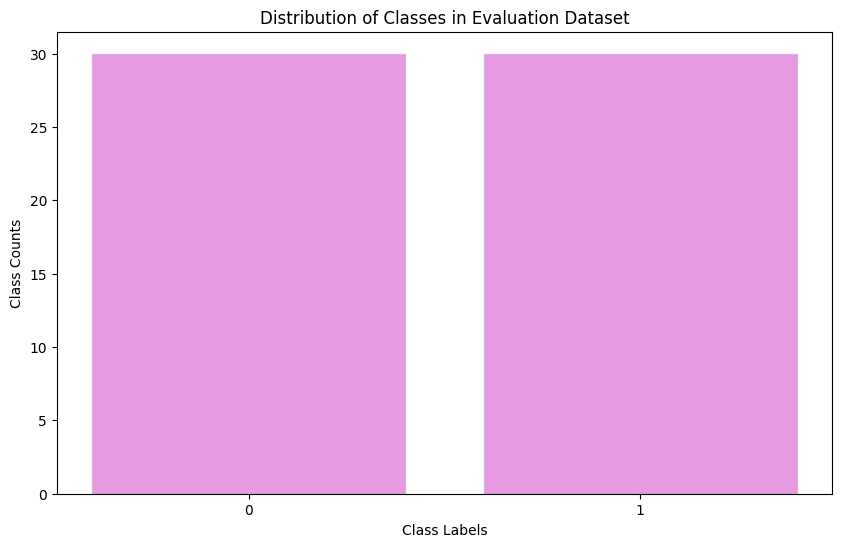

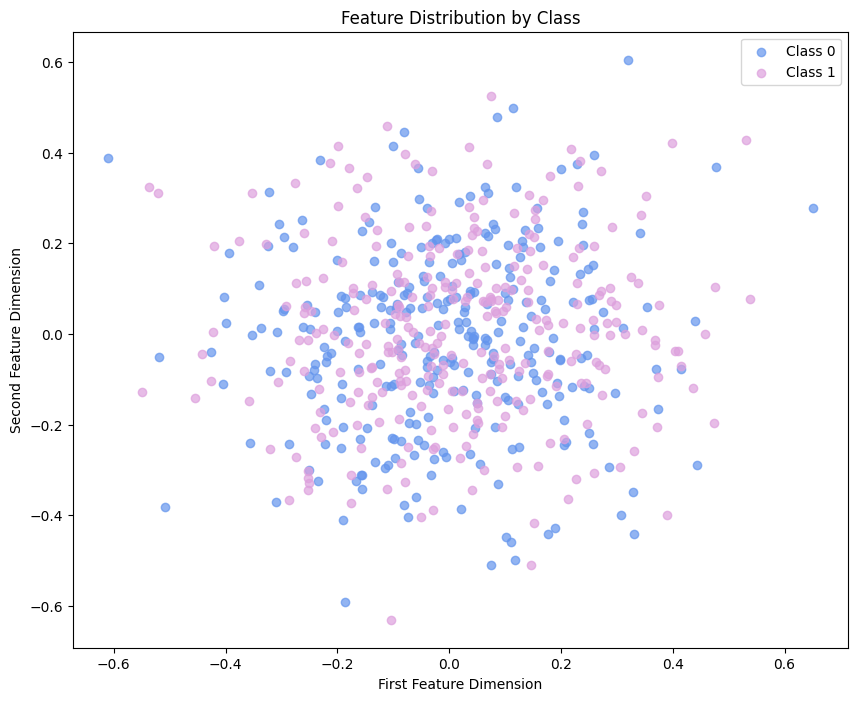

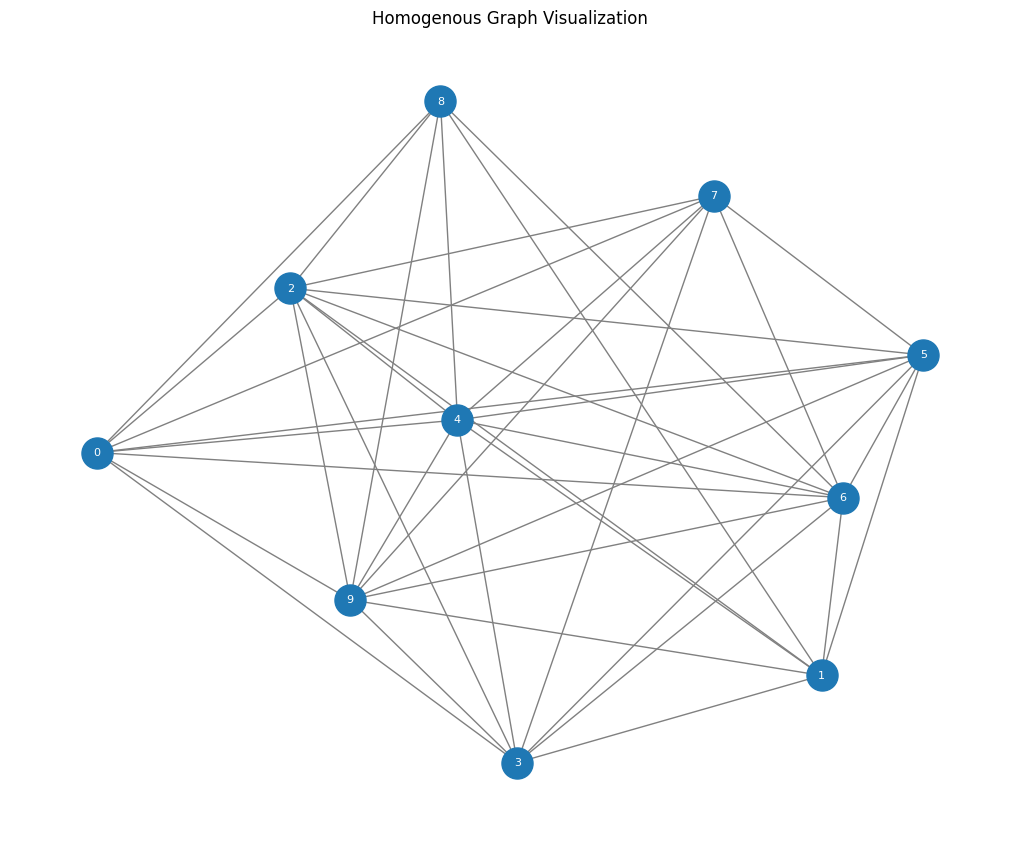

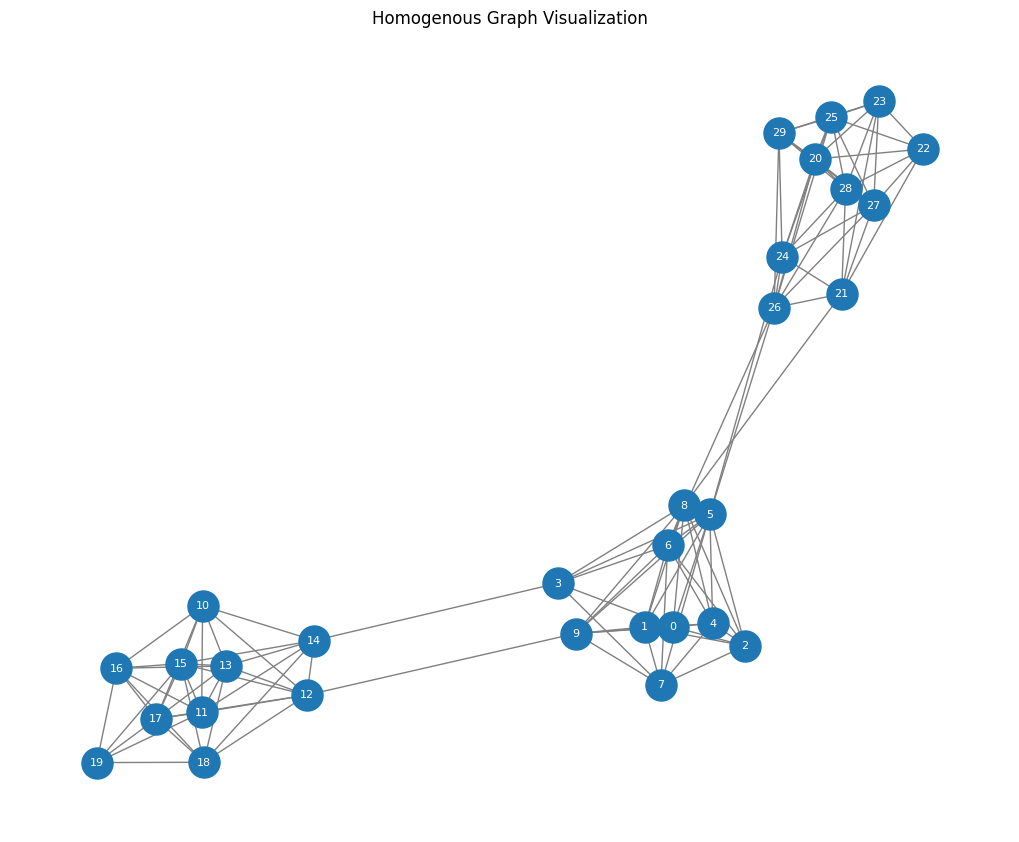

In [231]:
# Run the above scripts for train and eval. What do you observe?
def find_X_A_for_label(list_of_data,label=1):
    """Label"""
    for X,A,y in list_of_data:
        if y==label:
            return X,A

# Load data
train_data = read_json_data(TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
eval_data = read_json_data(EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# Getting Labels
train_labels = [int(y) for _,_,y in train_data]
eval_labels = [int(y) for _,_,y in eval_data]

# Getting Features
train_features_0 = [X.numpy() for X, _, y in train_data if y == 0]
train_features_1 = [X.numpy() for X, _, y in train_data if y == 1]

eval_features_0 = [X.numpy() for X, _, y in eval_data if y == 0]
eval_features_1 = [X.numpy() for X, _, y in eval_data if y == 1]

# Find a graph for each of the classes
X0_train, A0_train = find_X_A_for_label(train_data, 0)
X1_train, A1_train = find_X_A_for_label(train_data, 1)

X0_eval,A0_eval = find_X_A_for_label(eval_data, 0)
X1_eval, A1_eval = find_X_A_for_label(eval_data, 1)

# Plotting Train
plot_class_distribution(train_labels, dataset_name='Training', save=True, plot_name=f"train_class_distribution")
visualise_graph_features(train_features_0, train_features_1, save=True, plot_name=f"train_graph_features")
plot_graph_topology(A0_train, save=True, plot_name=f"train_topology_class_0")
plot_graph_topology(A1_train, save=True, plot_name=f"train_topology_class_1")

# Plotting Eval
plot_class_distribution(eval_labels, dataset_name='Evaluation', save=True, plot_name=f"eval_class_distribution")
visualise_graph_features(eval_features_0, eval_features_1, save=True, plot_name=f"eval_graph_features")
plot_graph_topology(A0_eval, save=True, plot_name=f"eval_topology_class_0")
plot_graph_topology(A1_eval, save=True, plot_name=f"eval_topology_class_1")

## Question 1.3 - Overcoming Dataset Challenges

In this section, you will attempt to address the challenges identified by improving the model or training process.

### Q1.3.a - Adapting the GCN

Modify your GCN implementation from Q1.1 to accept the number of layers and output dimension (i.e. the graph embedding dimension) as parametes. \
Experiment with different hyperparameters, such as:

• Number of layers.

• Hidden dimension size.

You will implement:

• Implement GCN as described above.

• Experiment with hyperparameters and report the results and plots.

Hint: The ModuleList class might be useful.

In [ ]:
# SOLUTION Q1.3.a

# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################
class MyGCNLayer2(nn.Module):
    """
    A single layer of a Graph Convolutional Network (GCN).
    """
    def __init__(self, input_dim, output_dim, use_nonlinearity=True):
        super(MyGCNLayer2, self).__init__()
        self.use_nonlinearity = use_nonlinearity
        self.Omega = nn.Parameter(torch.randn(input_dim, output_dim) * torch.sqrt(torch.tensor(2.0) / (input_dim + output_dim)))
        self.beta = nn.Parameter(torch.zeros(output_dim))

    def forward(self, H_k, A_normalized):
        agg = torch.matmul(A_normalized, H_k) # local agg
        H_k_next = torch.matmul(agg, self.Omega) + self.beta
        # Batch normalization?
        # Dropout?
        return F.relu(H_k_next) if self.use_nonlinearity else H_k_next

class MyGraphNeuralNetwork2(nn.Module):
    """
    A simple Graph Neural Network model using a variable number of layers of Graph Convolutional Network (GCN)
    for binary classification. The sigmoid activation is applied in the output layer only if
    use_nonlinearity is set to True.
    """
    def __init__(self, input_dim, hidden_dim, num_layers=2, output_dim=1, num_classes=1):
        super(MyGraphNeuralNetwork2, self).__init__()   
        # Define GCN layers
        self.layers = nn.ModuleList()
        self.num_classes = num_classes
        self.graph_embedding_dim = output_dim

        in_dim = input_dim
        out_dim = hidden_dim
        use_nonlinearity = True
        for layer in range(num_layers):
            self.layers.append(MyGCNLayer2(input_dim=in_dim, output_dim=out_dim, use_nonlinearity=use_nonlinearity))
            # print(f"Layer {layer+1}: {in_dim} -> {out_dim}; Nonlinearity: {use_nonlinearity}")
            in_dim = hidden_dim
            if layer == num_layers - 2:
                out_dim = output_dim
                use_nonlinearity = False
            else:
                out_dim = hidden_dim

        # Added Classification Head
        self.fc = nn.Linear(output_dim, num_classes)

    def forward(self, A, X, graph_aggregation_method='mean', **kwargs):
        # Apply self-connections and normalize adjacency matrix
        A = A + torch.eye(A.size(0)) # to get A_tilde
        A_normalized = symmetric_normalize(A)
        # Pass through all GCN layers
        H_k = X
        graph_embedding = []
        for layer in self.layers:
            H_k = layer(H_k, A_normalized)
            graph_embedding.append(H_k)

        # Perform graph aggregation based on the method passed as parameter
        aggregated_output = global_aggregation(H_k, graph_aggregation_method)
        # Classification Head: if final graph embedding size doesn't match the classification output
        if self.graph_embedding_dim != self.num_classes:
            aggregated_output = self.fc(aggregated_output)
        graph_output = torch.sigmoid(aggregated_output)

        if torch.isnan(graph_output).any():
            graph_output = torch.where(torch.isnan(graph_output), torch.zeros_like(graph_output), graph_output)

        if kwargs.get("return_graph_embedding", None):
            return graph_output, graph_embedding
        else:
            return graph_output
        
# ####################################################
# END OF MODIFICATION
# ####################################################


 MyGraphNeuralNetwork2(
  (layers): ModuleList(
    (0-1): 2 x MyGCNLayer2()
  )
  (fc): Linear(in_features=8, out_features=1, bias=True)
)
------- Using 'mean' aggregation -------
Epoch 10:
     Train Loss: 0.515170798694353, Train Accuracy: 0.7678
     Validation Loss: 0.8669830458859603, Validation Accuracy: 0.5000
     Training F1: 0.4343, Validation F1: 0.3333
Epoch 20:
     Train Loss: 0.48050764003565527, Train Accuracy: 0.7820
     Validation Loss: 0.9039536252617836, Validation Accuracy: 0.5000
     Training F1: 0.4955, Validation F1: 0.3333
Epoch 30:
     Train Loss: 0.45728512686540446, Train Accuracy: 0.8199
     Validation Loss: 0.9517374598731597, Validation Accuracy: 0.5333
     Training F1: 0.6308, Validation F1: 0.4254
Epoch 40:
     Train Loss: 0.44251776762942285, Train Accuracy: 0.8341
     Validation Loss: 0.9889484679947297, Validation Accuracy: 0.5500
     Training F1: 0.6735, Validation F1: 0.4555
Epoch 50:
     Train Loss: 0.4289908589556884, Train Accuracy: 0

<Figure size 1000x600 with 0 Axes>

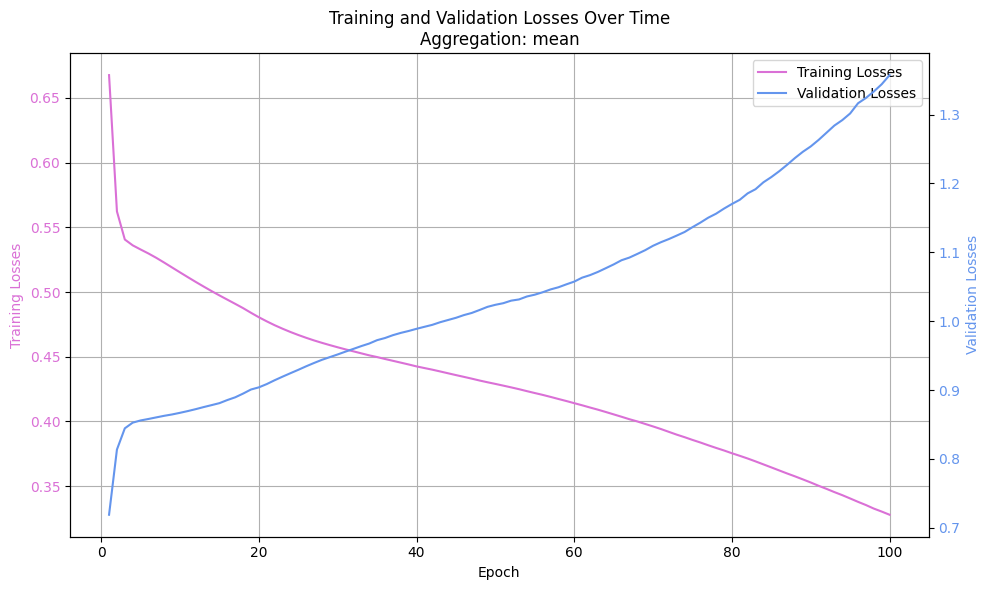

<Figure size 1000x600 with 0 Axes>

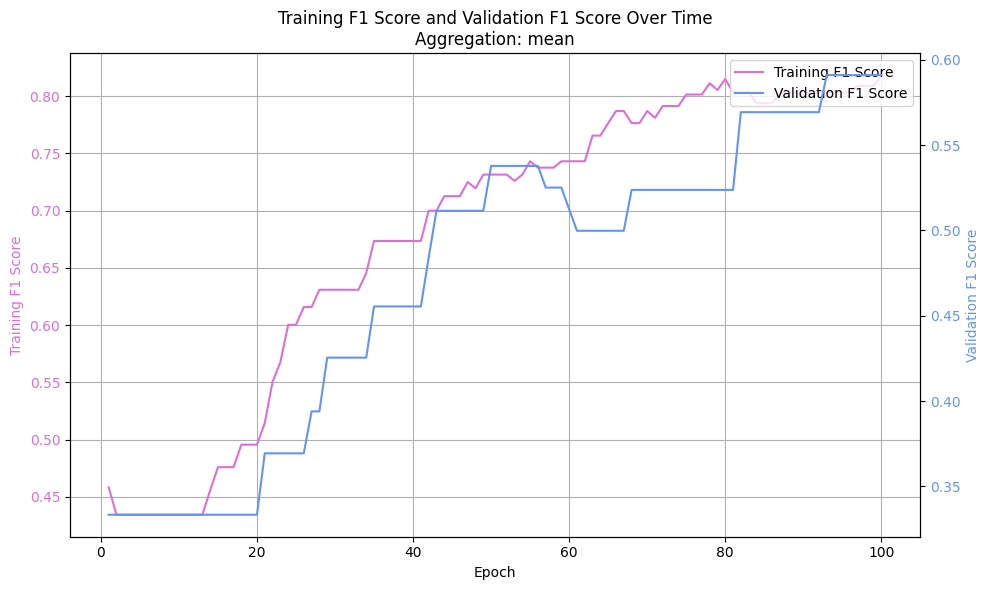


 MyGraphNeuralNetwork2(
  (layers): ModuleList(
    (0-1): 2 x MyGCNLayer2()
  )
  (fc): Linear(in_features=8, out_features=1, bias=True)
)
------- Using 'sum' aggregation -------
Epoch 10:
     Train Loss: 0.27342818103941335, Train Accuracy: 0.8095
     Validation Loss: 0.5203083910048008, Validation Accuracy: 0.5667
     Training F1: 0.6470, Validation F1: 0.4665
Epoch 20:
     Train Loss: 0.21734637038649193, Train Accuracy: 0.8929
     Validation Loss: 0.432570525802051, Validation Accuracy: 0.7833
     Training F1: 0.8341, Validation F1: 0.7727
Epoch 30:
     Train Loss: 0.17388207266741942, Train Accuracy: 0.9286
     Validation Loss: 0.36753483475185933, Validation Accuracy: 0.8000
     Training F1: 0.8960, Validation F1: 0.7917
Epoch 40:
     Train Loss: 0.13505789718016917, Train Accuracy: 0.9881
     Validation Loss: 0.3186271988010655, Validation Accuracy: 0.8500
     Training F1: 0.9841, Validation F1: 0.8465
Epoch 50:
     Train Loss: 0.10216481650197584, Train Accuracy:

<Figure size 1000x600 with 0 Axes>

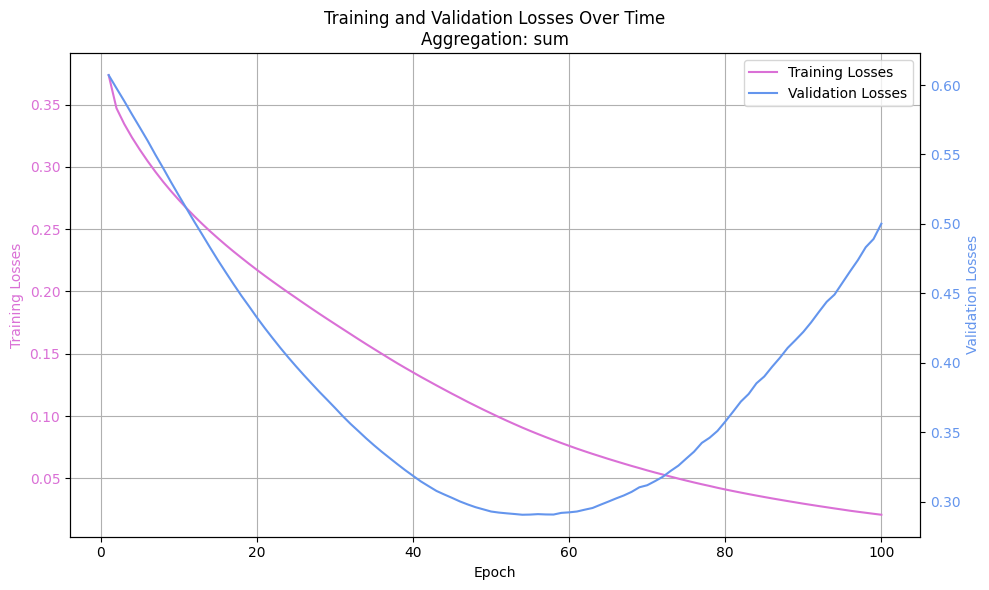

<Figure size 1000x600 with 0 Axes>

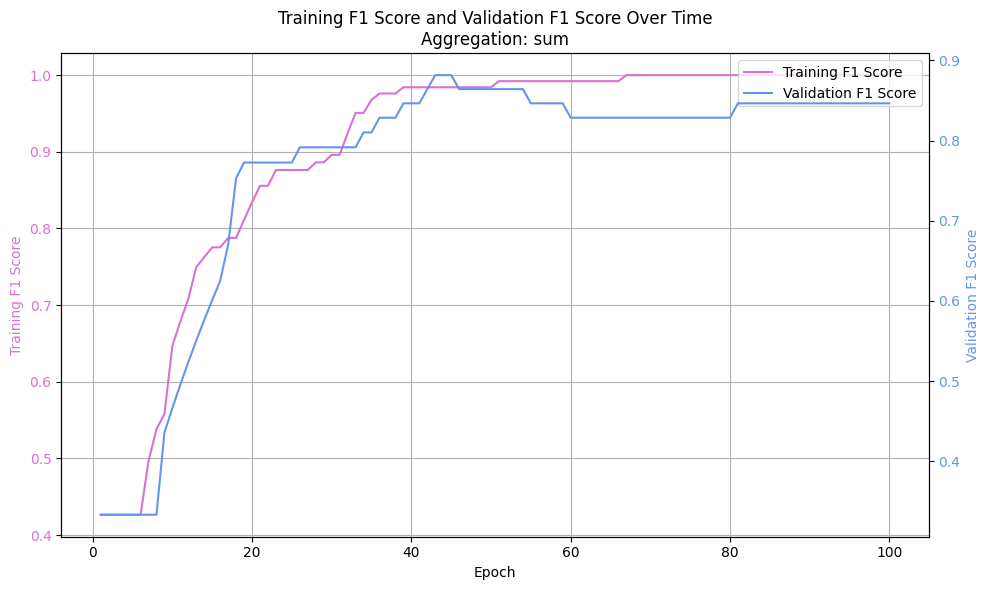


 MyGraphNeuralNetwork2(
  (layers): ModuleList(
    (0-1): 2 x MyGCNLayer2()
  )
  (fc): Linear(in_features=8, out_features=1, bias=True)
)
------- Using 'max' aggregation -------
Epoch 10:
     Train Loss: 0.49603572426669634, Train Accuracy: 0.7313
     Validation Loss: 0.7102008678019047, Validation Accuracy: 0.5000
     Training F1: 0.4224, Validation F1: 0.3333
Epoch 20:
     Train Loss: 0.38719520459313, Train Accuracy: 0.8433
     Validation Loss: 0.5566882926349839, Validation Accuracy: 0.6667
     Training F1: 0.7457, Validation F1: 0.6250
Epoch 30:
     Train Loss: 0.2627411193089254, Train Accuracy: 0.9179
     Validation Loss: 0.3848590226455902, Validation Accuracy: 0.8333
     Training F1: 0.8859, Validation F1: 0.8286
Epoch 40:
     Train Loss: 0.153354809275453, Train Accuracy: 0.9776
     Validation Loss: 0.27343360425438734, Validation Accuracy: 0.9333
     Training F1: 0.9718, Validation F1: 0.9333
Epoch 50:
     Train Loss: 0.09407868787708927, Train Accuracy: 0.98

<Figure size 1000x600 with 0 Axes>

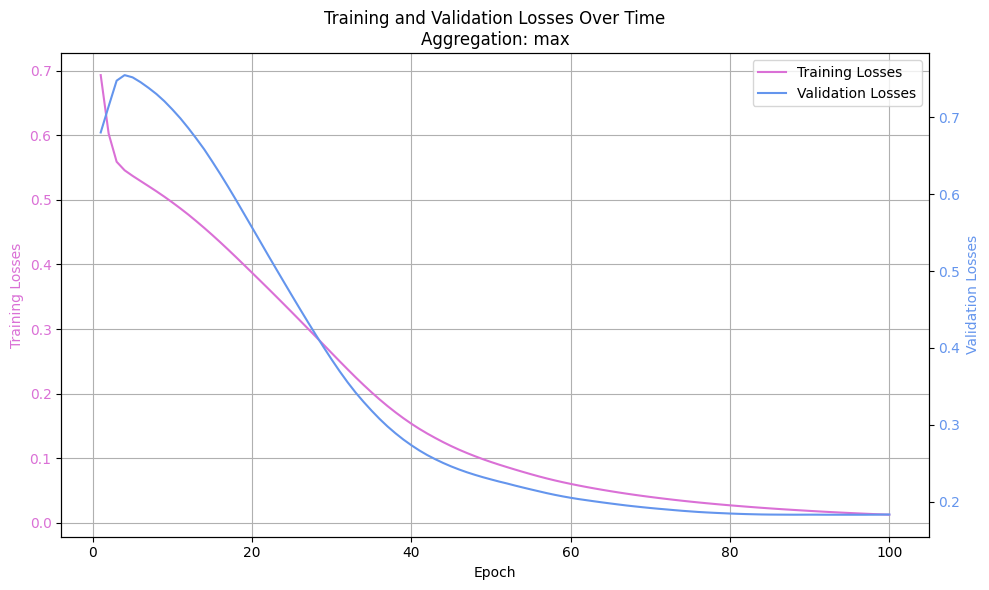

<Figure size 1000x600 with 0 Axes>

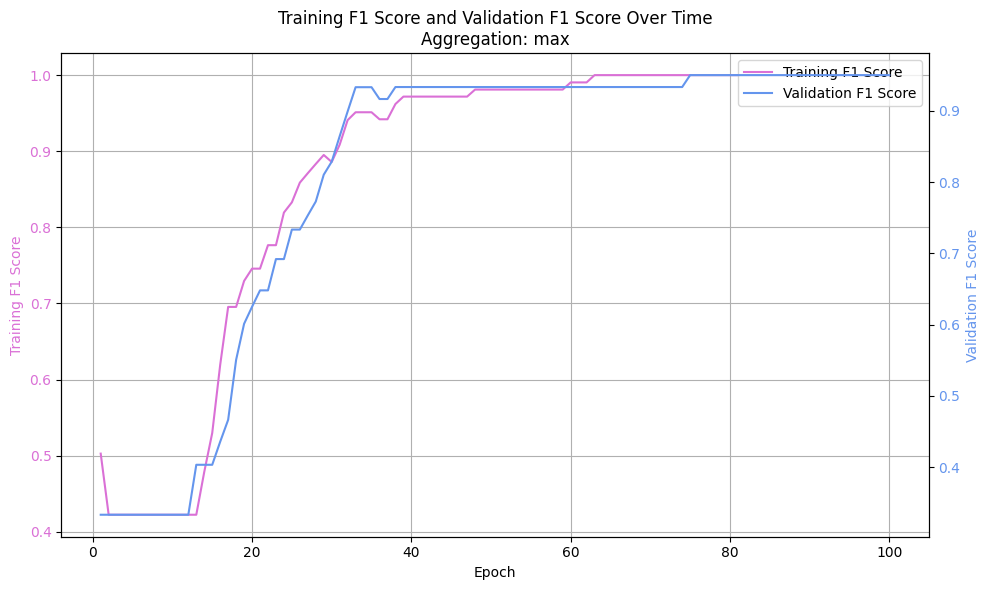

In [233]:
# Run different hyper params here
from statistics import mean
def split_training_data(dataset, train_ratio=0.8, shuffle=True):
    """
    Splits the dataset into training and evaluation sets based on the
    split ratio given as parameter.
    Optionally, the dataset can be randomly shuffled before splitting.
    Params:
        - dataset (list): The dataset to split, as a list of (X,A,y), features, Adj Matrix, and label per Graph
        - train_ratio (float): The ratio of the dataset to use for training (defaults to 80% train and 20% validation)
        - shuffle (bool): Whether to shuffle the dataset before splitting(defaults to True)
    Returns:    
        - train_data (list): The training dataset split
        - eval_data (list): The evaluation dataset split
    """
    if shuffle:
        random.shuffle(dataset)
    train_data = dataset[:int(train_ratio * len(dataset))]
    eval_data = dataset[int(train_ratio * len(dataset)):]
    return train_data, eval_data


# Load data
train_data = read_json_data(TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
eval_data = read_json_data(EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# Initialising the model
input_dim = 10
hidden_dim = 8
layers = 2
output_dim = 8


aggregation_methods = ["mean", "sum", "max"]
averaged_train_acc = []
averaged_eval_acc = []


num_epochs = 100
for i,aggregation in enumerate(aggregation_methods):

    model = MyGraphNeuralNetwork2(input_dim, hidden_dim, output_dim=output_dim, num_layers=layers)
    print("\n", model)

    # Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Splitting the Data
    train_data, val_data = split_training_data(train_data, 0.8)

    # TRAIN
    print(f"------- Using '{aggregation}' aggregation -------")
    train_losses, train_accuracies, validation_losses, validation_accuracies, train_F1, eval_F1 = train_model(
        model, 
        optimizer, 
        criterion, 
        train_data, 
        eval_data, 
        epochs=num_epochs, 
        graph_aggregation_method=aggregation,
        verbose=True,
        f1=True
    )
    plot_training_and_validation(train_losses, validation_losses, aggregation=aggregation, graph1_label="Training Losses", graph2_label="Validation Losses", x_label="Epoch", title=f"Training and Validation Losses Over Time\nAggregation: {aggregation}")#, save=True, plot_name=f"{aggregation}_loss")
    plot_training_and_validation(train_F1, eval_F1, aggregation=aggregation, graph1_label="Training F1 Score", graph2_label="Validation F1 Score", x_label="Epoch", title=f"Training F1 Score and Validation F1 Score Over Time\nAggregation: {aggregation}")#, save=True, plot_name=f"{aggregation}_f1")

    averaged_train_acc.append(mean(train_accuracies))
    averaged_eval_acc.append(mean(validation_accuracies))

### Q1.3.b - Improving the Model
Identify and implement three different methods to overcome the challenges discovered in
Q1.2. Your goal is to achieve the highest possible score. You may experiment with:

• Model architecture modifications.

• Data preprocessing techniques.

• Hyperparameter tuning.

• Loss function adjustments.

<Figure size 1000x600 with 0 Axes>

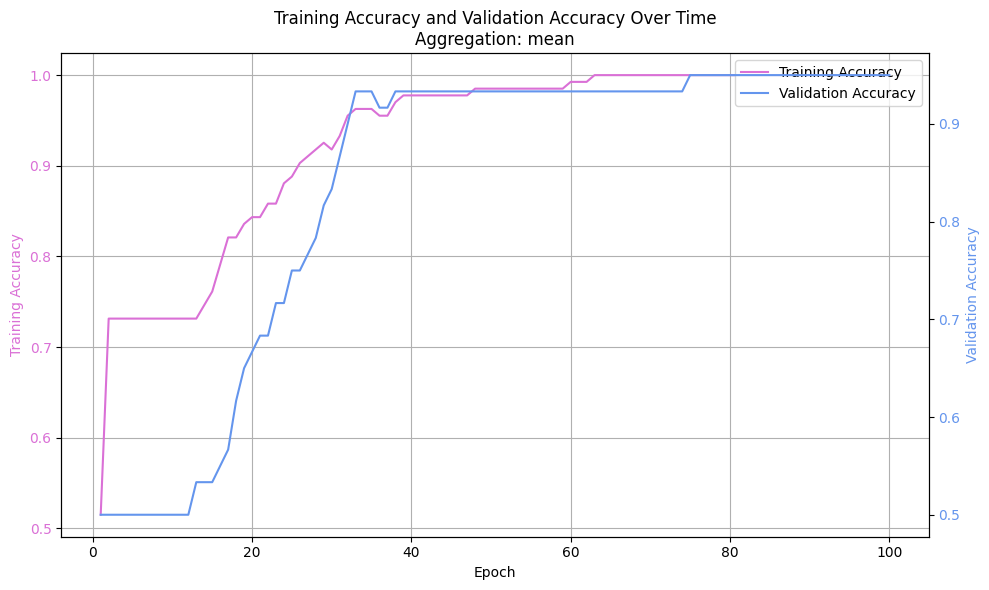

In [234]:
# SOLUTION Q1.3.b

# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################

# Call this function in the end.
plot_training_and_validation(train_accuracies, validation_accuracies)

# ####################################################
# END OF MODIFICATION
# ####################################################

### Q1.3.c - Evaluating the Best Model

Plot the performance of your best model over 100 epochs or more, averaged over multiple
random (i.i.d.) runs (at least 10 runs) to produce a smoothed training and evaluation accuracy
curve. 

Note: Your score will be based on the smoothed curve.

Hints:

• Set verbose=False in the train model function to suppress excessive logging.

• Use np.mean with an axis parameter to compute the average performance over multiple
runs.


<Figure size 1000x600 with 0 Axes>

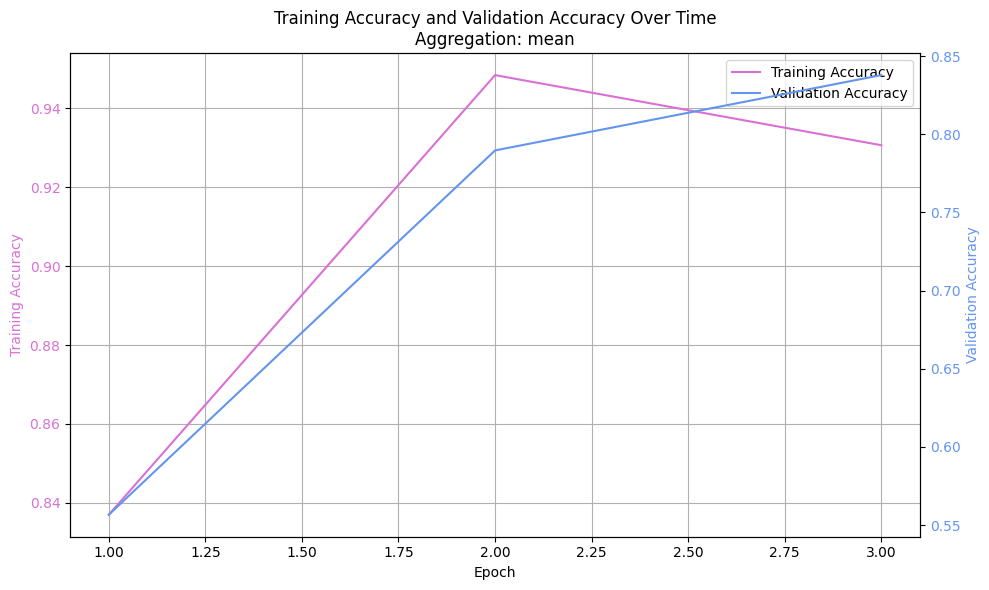

In [235]:
# SOLUTION Q1.3.c - Smooth Curve

# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################

# Call this function in the end (with the averaged values)
plot_training_and_validation(averaged_train_acc, averaged_eval_acc)

# ####################################################
# END OF MODIFICATION
# ####################################################